# Clasificación multiclase

## Introduction

En este ejercicio se implementa la regresion one-vs-all y una red neuronal para reconocimiento de digitos.

Antes de empezar la ejecución de las partes de codigo correspondienters a los ejercicios, se requiere importar todas las librerias necesarias.

In [1]:
# utilizado para la manipulación de directorios y rutas
import os

# Cálculo científico y vectorial para python
import numpy as np

# Libreria para graficos
from matplotlib import pyplot

# Modulo de optimizacion en scipy
from scipy import optimize

# modulo para cargar archivos en formato MATLAB
from scipy.io import loadmat

# le dice a matplotlib que incruste gráficos en el cuaderno
%matplotlib inline

import pandas as pd

## 1 Clasificación multiclase

Para este ejercicio, se usará regresión logística y redes neuronales para reconocer dígitos escritos a mano (de 0 a 9). El reconocimiento automático de dígitos escritos a mano se usa ampliamente en la actualidad, desde el reconocimiento de códigos postales (códigos postales) en sobres de correo hasta el reconocimiento de montos escritos en cheques bancarios. Este ejercicio  mostrará cómo los métodos que ha aprendido se pueden utilizar para esta tarea de clasificación.

La primera parte del ejercicio, extenderá la implementación anterior de la regresión logística y la aplicará a la clasificación de uno contra todos (one vs all).

### 1.1 Dataset

Se proporciona un conjunto de datos en `ex3data1.mat` que contiene 5000 ejemplos de entrenamiento de dígitos escritos a mano (este es un subconjunto del conjunto de datos de dígitos escritos a mano [MNIST] http://yann.lecun.com/exdb/mnist)). El formato `.mat` significa que los datos se han guardado en un formato de matriz nativo Octave/MATLAB, en lugar de un formato de texto (ASCII) como un archivo csv. Usamos el formato `.mat` aquí para mostrar los diferentes formatos en los que se pueden presentar los datasets. Python proporciona mecanismos para cargar el formato nativo de MATLAB usando la función `loadmat` dentro del módulo` scipy.io`. Esta función devuelve un diccionario de Python con claves que contienen los nombres de las variables dentro del archivo `.mat`.

Hay 5000 ejemplos de entrenamiento en `ex3data1.mat`, donde cada ejemplo de entrenamiento es una imagen en escala de grises de 20 píxeles por 20 píxeles del dígito. Cada píxel está representado por un número de punto flotante que indica la intensidad de la escala de grises en esa ubicación. La cuadrícula de 20 por 20 píxeles se "desenrolla" en un vector de 400 dimensiones. Cada uno de estos ejemplos de entrenamiento se convierte en una sola fila en nuestra matriz de datos "X". Esto da una matriz `X` de 5000 por 400 donde cada fila es un ejemplo de entrenamiento para una imagen de dígitos escrita a mano.

$$ X = \begin{bmatrix} - \: (x^{(1)})^T \: - \\ -\: (x^{(2)})^T \:- \\ \vdots \\ - \: (x^{(m)})^T \:-  \end{bmatrix} $$

La segunda parte del conjunto de entrenamiento es un vector "y" de 5000 dimensiones que contiene etiquetas para el conjunto de entrenamiento. 

Se inicia el ejercicio cargando primero el conjunto de datos. 

In [2]:
import scipy.io

# Cargar el archivo .mat
mat = scipy.io.loadmat('emnist-letters.mat')

# Obtener las claves (nombres de las variables) del diccionario
column_names = []
for key in mat:
    if not key.startswith('__'):
        column_names.append(key)

# Mostrar los nombres de las columnas
print(column_names)

['dataset']


In [3]:
# Ingresar imágenes de dígitos de 28x28
input_layer_size  = 784

# 10 etiquetas, de 1 a 10 (tomar en cuenta que se asigna "0" a la etiqueta 10)
num_labels = 47


#  datos de entrenamiento almacenados en los arreglos X, y
#data = loadmat(os.path.join('Datasets', 'ex3data1.mat'))

data = loadmat('emnist-balanced.mat')

X, y = data['dataset'][0][0]['train'][0][0]['images'], data['dataset'][0][0]['train'][0][0]['labels'].ravel()
# establecer el dígito cero en 0, en lugar del 10 asignado a este conjunto de datos
# Esto se hace debido a que el conjunto de datos se utilizó en MATLAB donde no hay índice 0
y[y == 10] = 0

m = y.size

In [4]:
print(X)
print(y)

[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
[45 36 43 ... 23 31  8]


### 1.2 Visualización de los datos

Se comenzará visualizando un subconjunto del conjunto de entrenamiento. Se selecciona al azar, 100 filas de `X` y pasa esas filas a la función` displayData`. Esta función asigna cada fila a una imagen en escala de grises de 20 píxeles por 20 píxeles y muestra las imágenes juntas.

In [5]:
def displayData(X, example_width=None, figsize=(10, 10)):
    """
    Muestra datos 2D almacenados en X en una cuadrícula apropiada.
    """
    # Calcula filas, columnas
    if X.ndim == 2:
        m, n = X.shape
    elif X.ndim == 1:
        n = X.size
        m = 1
        X = X[None]  # Promocionar a una matriz bidimensional
    else:
        raise IndexError('La entrada X debe ser 1 o 2 dimensinal.')

    example_width = example_width or int(np.round(np.sqrt(n)))
    example_height = n / example_width

    # Calcula el numero de elementos a mostrar
    display_rows = int(np.floor(np.sqrt(m)))
    display_cols = int(np.ceil(m / display_rows))

    fig, ax_array = pyplot.subplots(display_rows, display_cols, figsize=figsize)
    fig.subplots_adjust(wspace=0.025, hspace=0.025)

    ax_array = [ax_array] if m == 1 else ax_array.ravel()

    for i, ax in enumerate(ax_array):
        ax.imshow(X[i].reshape(example_width, example_width, order='F'),
                  cmap='Greys', extent=[0, 1, 0, 1])
        ax.axis('off')

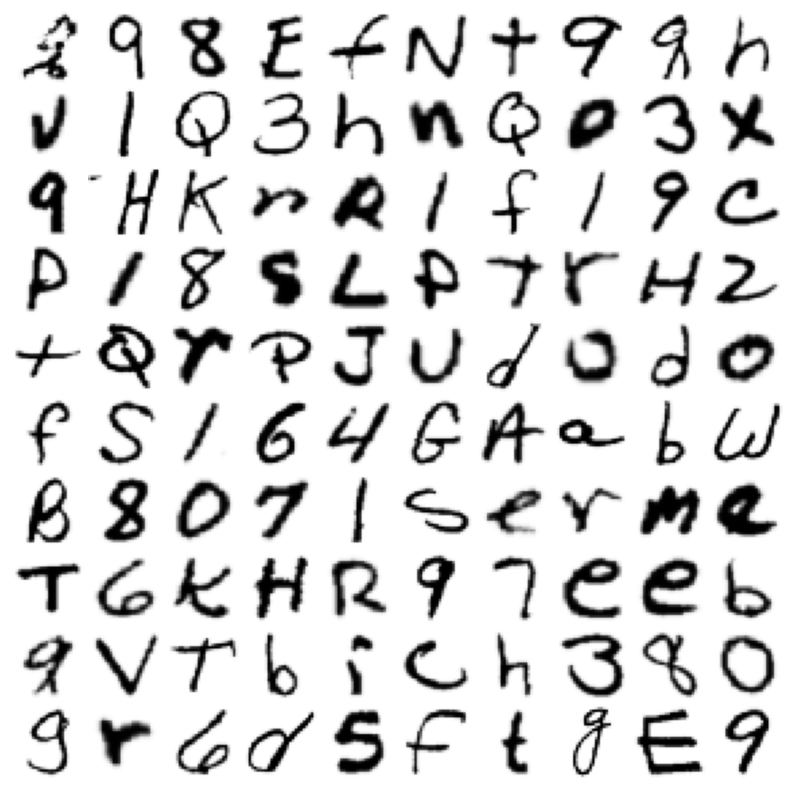

In [6]:
# Selecciona aleatoriamente 100 puntos de datos para mostrar
rand_indices = np.random.choice(m, 100, replace=False)
sel = X[rand_indices, :]

displayData(sel)

### 1.3 Vectorización de regresión logística

Se utilizará múltiples modelos de regresión logística uno contra todos para construir un clasificador de clases múltiples. Dado que hay 10 clases, deberá entrenar 10 clasificadores de regresión logística separados. Para que esta capacitación sea eficiente, es importante asegurarse de que el código esté bien vectorizado.

En esta sección, se implementará una versión vectorizada de regresión logística que no emplea ningún bucle "for".

Para probar la regresión logística vectorizada, se usara datos personalizados como se definen a continuación.

In [7]:
# valores de prueba para los parámetros theta
theta_t = np.array([-2, -1, 1, 2], dtype=float)

# valores de prueba para las entradas
X_t = np.concatenate([np.ones((5, 1)), np.arange(1, 16).reshape(5, 3, order='F')/10.0], axis=1)
print(X_t)
# valores de testeo para las etiquetas
y_t = np.array([1, 0, 1, 0, 1])

# valores de testeo para el parametro de regularizacion
lambda_t = 3

[[1.  0.1 0.6 1.1]
 [1.  0.2 0.7 1.2]
 [1.  0.3 0.8 1.3]
 [1.  0.4 0.9 1.4]
 [1.  0.5 1.  1.5]]


<a id="section1"></a>
#### 1.3.1 Vectorización de la funcion de costo

Se inicia escribiendo una versión vectorizada de la función de costo. En la regresión logística (no regularizada), la función de costo es

$$ J(\theta) = \frac{1}{m} \sum_{i=1}^m \left[ -y^{(i)} \log \left( h_\theta\left( x^{(i)} \right) \right) - \left(1 - y^{(i)} \right) \log \left(1 - h_\theta \left( x^{(i)} \right) \right) \right] $$

Para calcular cada elemento en la suma, tenemos que calcular $h_\theta(x^{(i)})$ para cada ejemplo $i$, donde $h_\theta(x^{(i)}) = g(\theta^T x^{(i)})$ y $g(z) = \frac{1}{1+e^{-z}}$ es la funcion sigmoidea. Resulta que podemos calcular esto rápidamente para todos los ejemplos usando la multiplicación de matrices. Definamos $X$ y $\theta$ como

$$ X = \begin{bmatrix} - \left( x^{(1)} \right)^T - \\ - \left( x^{(2)} \right)^T - \\ \vdots \\ - \left( x^{(m)} \right)^T - \end{bmatrix} \qquad \text{and} \qquad \theta = \begin{bmatrix} \theta_0 \\ \theta_1 \\ \vdots \\ \theta_n \end{bmatrix} $$

Luego, de calcular el producto matricial $X\theta$, se tiene: 

$$ X\theta = \begin{bmatrix} - \left( x^{(1)} \right)^T\theta - \\ - \left( x^{(2)} \right)^T\theta - \\ \vdots \\ - \left( x^{(m)} \right)^T\theta - \end{bmatrix} = \begin{bmatrix} - \theta^T x^{(1)}  - \\ - \theta^T x^{(2)} - \\ \vdots \\ - \theta^T x^{(m)}  - \end{bmatrix} $$

En la última igualdad, usamos el hecho de que $a^Tb = b^Ta$ if $a$ y $b$ son vectores. Esto permite calcular los productos $\theta^T x^{(i)}$ para todos los ejemplos $i$ en una linea de codigo.

#### 1.3.2 Vectorización del gradiente

Recordemos que el gradiente del costo de regresión logística (no regularizado) es un vector donde el elemento $j^{th}$ se define como
$$ \frac{\partial J }{\partial \theta_j} = \frac{1}{m} \sum_{i=1}^m \left( \left( h_\theta\left(x^{(i)}\right) - y^{(i)} \right)x_j^{(i)} \right) $$

Para vectorizar esta operación sobre el conjunto de datos, se inicia escribiendo todas las derivadas parciales explícitamente para todos $\theta_j$,

$$
\begin{align*}
\begin{bmatrix} 
\frac{\partial J}{\partial \theta_0} \\
\frac{\partial J}{\partial \theta_1} \\
\frac{\partial J}{\partial \theta_2} \\
\vdots \\
\frac{\partial J}{\partial \theta_n}
\end{bmatrix} = &
\frac{1}{m} \begin{bmatrix}
\sum_{i=1}^m \left( \left(h_\theta\left(x^{(i)}\right) - y^{(i)} \right)x_0^{(i)}\right) \\
\sum_{i=1}^m \left( \left(h_\theta\left(x^{(i)}\right) - y^{(i)} \right)x_1^{(i)}\right) \\
\sum_{i=1}^m \left( \left(h_\theta\left(x^{(i)}\right) - y^{(i)} \right)x_2^{(i)}\right) \\
\vdots \\
\sum_{i=1}^m \left( \left(h_\theta\left(x^{(i)}\right) - y^{(i)} \right)x_n^{(i)}\right) \\
\end{bmatrix} \\
= & \frac{1}{m} \sum_{i=1}^m \left( \left(h_\theta\left(x^{(i)}\right) - y^{(i)} \right)x^{(i)}\right) \\
= & \frac{1}{m} X^T \left( h_\theta(x) - y\right)
\end{align*}
$$

donde

$$  h_\theta(x) - y = 
\begin{bmatrix}
h_\theta\left(x^{(1)}\right) - y^{(1)} \\
h_\theta\left(x^{(2)}\right) - y^{(2)} \\
\vdots \\
h_\theta\left(x^{(m)}\right) - y^{(m)} 
\end{bmatrix} $$

Nota $x^{(i)}$ es un vector, mientras $h_\theta\left(x^{(i)}\right) - y^{(i)}$ es un escalar(simple número).
Para comprender el último paso de la derivación, dejemos $\beta_i = (h_\theta\left(x^{(m)}\right) - y^{(m)})$ y
observar que:

$$ \sum_i \beta_ix^{(i)} = \begin{bmatrix} 
| & | & & | \\
x^{(1)} & x^{(2)} & \cdots & x^{(m)} \\
| & | & & | 
\end{bmatrix}
\begin{bmatrix}
\beta_1 \\
\beta_2 \\
\vdots \\
\beta_m
\end{bmatrix} = x^T \beta
$$

donde los valores $\beta_i = \left( h_\theta(x^{(i)} - y^{(i)} \right)$.

La expresión anterior nos permite calcular todas las derivadas parciales sin bucles.
Si se siente cómodo con el álgebra lineal, le recomendamos que trabaje con las multiplicaciones de matrices anteriores para convencerse de que la versión vectorizada hace los mismos cálculos.

<div class="alert alert-box alert-warning">
** Consejo de depuración: ** El código de vectorización a veces puede ser complicado. Una estrategia común para la depuración es imprimir los tamaños de las matrices con las que está trabajando usando la propiedad `shape` de las matrices` numpy`.

Por ejemplo, dada una matriz de datos $X$ de tamaño $100\veces 20$ (100 ejemplos, 20 características) y $\theta$, un vector con tamaño $20$, puede observar que `np.dot (X, theta) `es una operación de multiplicación válida, mientras que` np.dot (theta, X) `no lo es.

Además, si tiene una versión no vectorizada de su código, puede comparar la salida de su código vectorizado y el código no vectorizado para asegurarse de que produzcan las mismas salidas.</div>
<a id="lrCostFunction"></a>

In [8]:
def sigmoid(z):
    """
    Calcula la sigmoide de z.
    """
    return 1.0 / (1.0 + np.exp(-z))

In [9]:
def lrCostFunction(theta, X, y, lambda_):
    """
    Calcula el costo de usar theta como parámetro para la regresión logística regularizada y 
    el gradiente del costo w.r.t. a los parámetros.
    
    Parametros
    ----------
    theta : array_like
        Parametro theta de la regresion logistica. Vector de la forma(shape) (n, ). n es el numero de caracteristicas 
        incluida la intercepcion
        
    X : array_like
        Dataset con la forma(shape) (m x n). m es el numero de ejemplos, y n es el numero de 
        caracteristicas (incluida la intercepcion).
    
    y : array_like
        El conjunto de etiquetas. Un vector con la forma (shape) (m, ). m es el numero de ejemplos
    
    lambda_ : float
        Parametro de regularización. 
    
    Devuelve
    -------
    J : float
        El valor calculado para la funcion de costo regularizada. 
    
    grad : array_like
        Un vector de la forma (shape) (n, ) que es el gradiente de la 
        función de costo con respecto a theta, en los valores actuales de theta..
    """
    # Inicializa algunos valores utiles
    m = y.size
    
    # convierte las etiquetas a valores enteros si son boleanos
    if y.dtype == bool:
        y = y.astype(int)
    
    J = 0
    grad = np.zeros(theta.shape)
    
    h = sigmoid(X.dot(theta.T))
    
    temp = theta
    temp[0] = 0
    
    J = (1 / m) * np.sum(-y.dot(np.log(h)) - (1 - y).dot(np.log(1 - h))) + (lambda_ / (2 * m)) * np.sum(np.square(temp))
    
    grad = (1 / m) * (h - y).dot(X) 
    grad = grad + (lambda_ / m) * temp

    return J, grad

#### 1.3.3 Vectorización regularizada de la regresión logística

Una vez implementada la vectorización para la regresión logística, corresponde agregarar regularización a la función de costo.
Para la regresión logística regularizada, la función de costo se define como

$$ J(\theta) = \frac{1}{m} \sum_{i=1}^m \left[ -y^{(i)} \log \left(h_\theta\left(x^{(i)} \right)\right) - \left( 1 - y^{(i)} \right) \log\left(1 - h_\theta \left(x^{(i)} \right) \right) \right] + \frac{\lambda}{2m} \sum_{j=1}^n \theta_j^2 $$

Tomar en cuenta que no debería regularizarse $\theta_0$ que se usa para el término de sesgo. En consecuencia, la derivada parcial del costo de regresión logística regularizado para $\theta_j$ se define como

$$
\begin{align*}
& \frac{\partial J(\theta)}{\partial \theta_0} = \frac{1}{m} \sum_{i=1}^m \left( h_\theta\left( x^{(i)} \right) - y^{(i)} \right) x_j^{(i)}  & \text{for } j = 0 \\
& \frac{\partial J(\theta)}{\partial \theta_0} = \left( \frac{1}{m} \sum_{i=1}^m \left( h_\theta\left( x^{(i)} \right) - y^{(i)} \right) x_j^{(i)} \right) + \frac{\lambda}{m} \theta_j & \text{for } j  \ge 1
\end{align*}
$$

<div class="alert alert-box alert-warning">
** Python/numpy Consejo: ** Al implementar la vectorización para la regresión logística regularizada, a menudo es posible que solo desee sumar y actualizar ciertos elementos de $\theta$. En `numpy`, puede indexar en las matrices para acceder y actualizar solo ciertos elementos.

Por ejemplo, A [:, 3: 5] = B [:, 1: 3] reemplazará las columnas con índice 3 a 5 de A con las columnas con índice 1 a 3 de B.   
Para seleccionar columnas (o filas) hasta el final de la matriz, puede dejar el lado derecho de los dos puntos en blanco.
Por ejemplo, A [:, 2:] solo devolverá elementos desde $3^{rd}$ a las últimas columnas de $A$.Si deja el tamaño de la mano izquierda de los dos puntos en blanco, seleccionará los elementos del principio de la matriz.
Por ejemplo, A [:,: 2] selecciona las dos primeras columnas y es equivalente a A [:, 0: 2]. Además, puede utilizar índices negativos para indexar matrices desde el final.
Por lo tanto, A [:,: -1] selecciona todas las columnas de A excepto la última columna, y A [:, -5:] selecciona la columna $5^{th}$ desde el final hasta la última columna.

Por lo tanto, podría usar esto junto con las operaciones de suma y potencia ($^{**}$) para calcular la suma de solo los elementos que le interesan (por ejemplo, `np.sum (z[1:]**2)`).
</div>


In [10]:
J, grad = lrCostFunction(theta_t, X_t, y_t, lambda_t)

print('Costo         : {:.6f}'.format(J))
print('Costo esperadot: 2.534819')
print('-----------------------')
print('Gradientes:')
print(' [{:.6f}, {:.6f}, {:.6f}, {:.6f}]'.format(*grad))
print('Gradientes esperados:')
print(' [0.146561, -0.548558, 0.724722, 1.398003]');

Costo         : 2.534819
Costo esperadot: 2.534819
-----------------------
Gradientes:
 [0.146561, -0.548558, 0.724722, 1.398003]
Gradientes esperados:
 [0.146561, -0.548558, 0.724722, 1.398003]


<a id="section2"></a>
### 1.4 Clasificacion One-vs-all
En esta parte del ejercicio, se implementará la clasificación de uno contra todos mediante el entrenamiento de múltiples clasificadores de regresión logística regularizados, uno para cada una de las clases $K$ en nuestro conjunto de datos. En el conjunto de datos de dígitos escritos a mano, $K = 10$, pero su código debería funcionar para cualquier valor de $K$.

El argumento `y` de esta función es un vector de etiquetas de 0 a 9. Al entrenar el clasificador para la clase $k \in \{0, ..., K-1 \} $, querrá un vector K-dimensional de etiquetas $y$, donde $y_j \ in 0, 1$ indica si la instancia de entrenamiento $j ^ {th}$ pertenece a la clase $k$ $(y_j = 1)$, o si pertenece a una clase diferente $(y_j = 0)$.

Además, se utiliza `optimize.minimize` de scipy para este ejercicio.
<a id="oneVsAll"></a>

In [11]:
def oneVsAll(X, y, num_labels, lambda_):
    """
    Trains num_labels logistic regression classifiers and returns
    each of these classifiers in a matrix all_theta, where the i-th
    row of all_theta corresponds to the classifier for label i.
    
    Parameters
    ----------
    X : array_like
        The input dataset of shape (m x n). m is the number of 
        data points, and n is the number of features. Note that we 
        do not assume that the intercept term (or bias) is in X, however
        we provide the code below to add the bias term to X. 
    
    y : array_like
        The data labels. A vector of shape (m, ).
    
    num_labels : int
        Number of possible labels.
    
    lambda_ : float
        The logistic regularization parameter.
    
    Returns
    -------
    all_theta : array_like
        The trained parameters for logistic regression for each class.
        This is a matrix of shape (K x n+1) where K is number of classes
        (ie. `numlabels`) and n is number of features without the bias.
    """
    # algunas variables utiles
    m, n = X.shape
    
    all_theta = np.zeros((num_labels, n + 1))

    # Agrega unos a la matriz X
    X = np.concatenate([np.ones((m, 1)), X], axis=1)

    for c in np.arange(num_labels):
        initial_theta = np.zeros(n + 1)
        options = {'maxiter': 50}
        res = optimize.minimize(lrCostFunction, 
                                initial_theta, 
                                (X, (y == c), lambda_), 
                                jac=True, 
                                method='CG',
                                options=options) 
        
        all_theta[c] = res.x

    return all_theta

In [12]:
lambda_ = 0.5
all_theta = oneVsAll(X, y, num_labels, lambda_)

C:\Users\qvano\AppData\Local\Temp\ipykernel_13276\1889279066.py:5: RuntimeWarning: overflow encountered in exp
  return 1.0 / (1.0 + np.exp(-z))
C:\Users\qvano\AppData\Local\Temp\ipykernel_13276\1892987983.py:46: RuntimeWarning: divide by zero encountered in log
  J = (1 / m) * np.sum(-y.dot(np.log(h)) - (1 - y).dot(np.log(1 - h))) + (lambda_ / (2 * m)) * np.sum(np.square(temp))
C:\Users\qvano\AppData\Local\Temp\ipykernel_13276\1892987983.py:46: RuntimeWarning: divide by zero encountered in log
  J = (1 / m) * np.sum(-y.dot(np.log(h)) - (1 - y).dot(np.log(1 - h))) + (lambda_ / (2 * m)) * np.sum(np.square(temp))
C:\Users\qvano\AppData\Local\Temp\ipykernel_13276\1889279066.py:5: RuntimeWarning: overflow encountered in exp
  return 1.0 / (1.0 + np.exp(-z))
C:\Users\qvano\AppData\Local\Temp\ipykernel_13276\1892987983.py:46: RuntimeWarning: divide by zero encountered in log
  J = (1 / m) * np.sum(-y.dot(np.log(h)) - (1 - y).dot(np.log(1 - h))) + (lambda_ / (2 * m)) * np.sum(np.square(temp))

<a id="section3"></a>
#### 1.4.1 Prediccion One-vs-all

Después de entrenar el clasificador de one-vs-all, se puede usarlo para predecir el dígito contenido en una imagen determinada. Para cada entrada, debe calcular la "probabilidad" de que pertenezca a cada clase utilizando los clasificadores de regresión logística entrenados. La función de predicción one-vs-all seleccionará la clase para la cual el clasificador de regresión logística correspondiente genera la probabilidad más alta y devolverá la etiqueta de clase (0, 1, ..., K-1) como la predicción para el ejemplo de entrada.

In [15]:
def predictOneVsAll(all_theta, X):
    """
    Devuelve un vector de predicciones para cada ejemplo en la matriz X.
    Tenga en cuenta que X contiene los ejemplos en filas. 
    all_theta es una matriz donde la i-ésima fila es un vector theta de regresión logística entrenada para la i-ésima clase. 
    Debe establecer p en un vector de valores de 0..K-1 (por ejemplo, p = [0, 2, 0, 1] 
    predice clases 0, 2, 0, 1 para 4 ejemplos).
    
    Parametros
    ----------
    all_theta : array_like
        The trained parameters for logistic regression for each class.
        This is a matrix of shape (K x n+1) where K is number of classes
        and n is number of features without the bias.
    
    X : array_like
        Data points to predict their labels. This is a matrix of shape 
        (m x n) where m is number of data points to predict, and n is number 
        of features without the bias term. Note we add the bias term for X in 
        this function. 
    
    Devuelve
    -------
    p : array_like
        The predictions for each data point in X. This is a vector of shape (m, ).
    """
    
    m = X.shape[0];
    num_labels = all_theta.shape[0]

    p = np.zeros(m)

    # Add ones to the X data matrix
    X = np.concatenate([np.ones((m, 1)), X], axis=1)
    p = np.argmax(sigmoid(X.dot(all_theta.T)), axis = 1)

    return p

Una vez que haya terminado, se llama a la función `predictOneVsAll` usando el valor aprendido de $\theta$. Debería apreciarse que la precisión del conjunto de entrenamiento es de aproximadamente 95,1% (es decir, clasifica correctamente el 95,1% de los ejemplos del conjunto de entrenamiento).

(112800, 784)
Precision del conjuto de entrenamiento: 68.15%
(1, 784)
(1, 785)
[13]


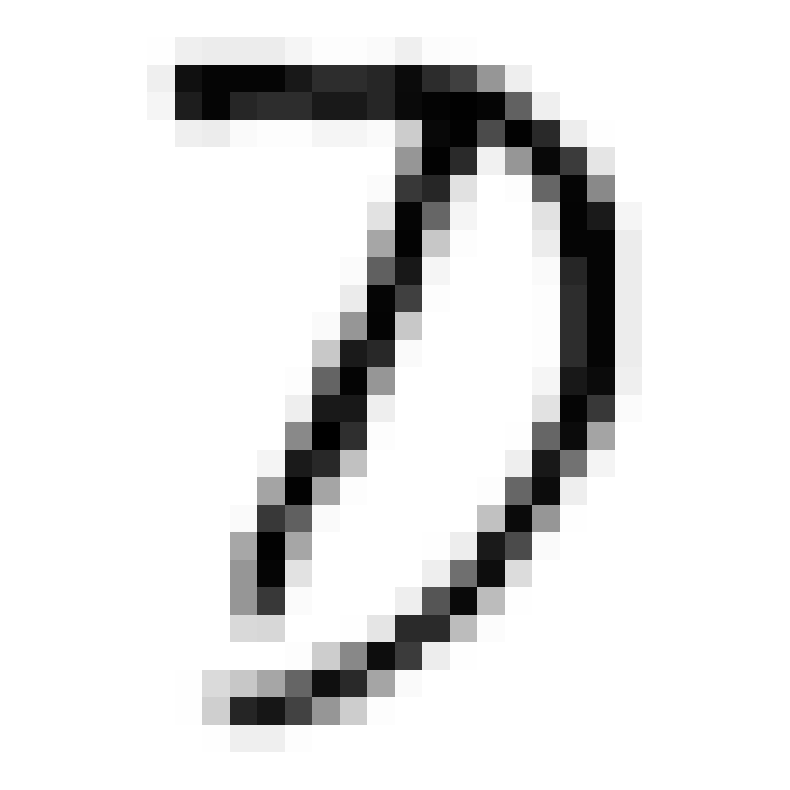

In [21]:
print(X.shape)
pred = predictOneVsAll(all_theta, X)
print('Precision del conjuto de entrenamiento: {:.2f}%'.format(np.mean(pred == y) * 100))
XPrueba = X[2437:2438, :].copy()
print(XPrueba.shape)
#print(np.ones((1)))
#print(XPrueba)
#p = np.zeros(1)
XPrueba = np.concatenate([np.ones((1, 1)), XPrueba], axis=1)
print(XPrueba.shape)
p = np.argmax(sigmoid(XPrueba.dot(all_theta.T)), axis = 1)
print(p)

displayData(X[2437:2438, :])